In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import geodatasets as gds

import matplotlib.pyplot as plt 
import seaborn as sns
import contextily as cx
import mapclassify as mc
import folium as fm
import seaborn as sns
import matplotlib as mpl
import osmnx as ox

In [2]:
# Read file

df_hour = pd.read_csv('Data/Data Files/passanten_hour_preprocessed.csv')

df_hour.head()

,timestamp,weather_condition,temperature,pedestrians_count,location_id,location_name,GeoPunkt,longitude,latitude,year,month,day,hour,day_of_week,day_month,season,day_season,is_weekend,is_holiday
0,2024-07-17 10:00:00+00:00,partly-cloudy-day,24.0,2926,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",9.930892,49.795012,2024,July,17,10,Wednesday,17-07,Summer,Wednesday_Summer,0,0
1,2024-07-17 10:00:00+00:00,partly-cloudy-day,24.0,1692,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",9.934698,49.794834,2024,July,17,10,Wednesday,17-07,Summer,Wednesday_Summer,0,0
2,2024-07-17 10:00:00+00:00,partly-cloudy-day,24.0,2316,476,Kaiserstraße,"49.798498976405355, 9.933887635731686",9.933534,49.797680,2024,July,17,10,Wednesday,17-07,Summer,Wednesday_Summer,0,0
3,2024-07-17 11:00:00+00:00,clear-day,24.0,2797,135,Schönbornstraße,"49.795490162266525, 9.931060093195851",9.930892,49.795012,2024,July,17,11,Wednesday,17-07,Summer,Wednesday_Summer,0,0
4,2024-07-17 11:00:00+00:00,clear-day,24.0,1552,470,Spiegelstraße,"49.79512717222457, 9.934114106308467",9.934698,49.794834,2024,July,17,11,Wednesday,17-07,Summer,Wednesday_Summer,0,0


In [3]:
# Berechne den durchschnittlichen Fußgängerverkehr über alle Stunden und Tage hinweg
average_pedestrians_overall = df_hour['pedestrians_count'].mean()

# Zeige das Ergebnis
average_pedestrians_overall


797.7784199200738

### Feature Engineering: Location Analysis

In [4]:
# Define tags for each category


sightseeing_tags = {
    'tourism': ['museum', 'attraction', 'viewpoint', 'zoo', 'theme_park', 'gallery', 'monument'],
    'historic': True,
    'leisure': ['park', 'garden']
}

transportation_hubs_tags = {
    'amenity': ['bus_station', 'taxi', 'car_rental', 'car_sharing']
}

shopping_tags = {
    'amenity': ['marketplace', 'food_court'],
    'shop': True
}

dining_and_entertainment_tags = {
    'amenity': ['bar', 'restaurant', 'cafe', 'fast_food']
}

# Load POIs within a 3km radius from the center of Würzburg for each category
pois_sightseeing = ox.features_from_address("Würzburg, Germany", dist=3000, tags=sightseeing_tags)
pois_transportation_hubs = ox.features_from_address("Würzburg, Germany", dist=3000, tags=transportation_hubs_tags)
pois_shopping = ox.features_from_address("Würzburg, Germany", dist=3000, tags=shopping_tags)
pois_dining_and_entertainment = ox.features_from_address("Würzburg, Germany", dist=3000, tags=dining_and_entertainment_tags)

# Convert to GeoDataFrames
pois_sightseeing = pois_sightseeing.to_crs(epsg=3857)
pois_transportation_hubs = pois_transportation_hubs.to_crs(epsg=3857)
pois_shopping = pois_shopping.to_crs(epsg=3857)
pois_dining_and_entertainment = pois_dining_and_entertainment.to_crs(epsg=3857)



In [5]:
# Function to filter columns and reset index
def filter_columns(pois, extra_columns=None):
    default_columns = ["element_type", "osmid", "name", "geometry"]
    if extra_columns:
        columns = default_columns + extra_columns
    else:
        columns = default_columns
    return pois.reset_index()[columns].dropna(subset=['geometry'])


# Apply the function to each POI DataFrame
pois_sightseeing = filter_columns(pois_sightseeing, ['tourism', 'historic', 'leisure'])
pois_transportation_hubs = filter_columns(pois_transportation_hubs, ['amenity'])
pois_shopping = filter_columns(pois_shopping, ['amenity', 'shop'])
pois_dining_and_entertainment = filter_columns(pois_dining_and_entertainment, ['amenity'])

# Concatenate all POIs into one DataFrame
pois = pd.concat([pois_sightseeing, pois_transportation_hubs, pois_shopping, pois_dining_and_entertainment], ignore_index=True)

pois.head()

,element_type,osmid,name,geometry,tourism,historic,leisure,amenity,shop
0,node,53900352,Festung Marienberg,POINT (1104205.058 6409951.533),attraction,castle,NaN,NaN,NaN
1,node,208338858,NaN,POINT (1104582.408 6410077.598),viewpoint,NaN,NaN,NaN,NaN
2,node,220311990,Frankenapostel,POINT (1104260.929 6409965.707),artwork,yes,NaN,NaN,NaN
3,node,223831375,NaN,POINT (1105297.914 6413095.966),viewpoint,NaN,NaN,NaN,NaN
4,node,251524261,NaN,POINT (1104617.485 6410411.468),viewpoint,NaN,NaN,NaN,NaN


In [6]:
# Count the number of POIs in each category
sightseeing_count = pois_sightseeing.shape[0]  # Total number of sightseeing POIs
transportation_count = pois_transportation_hubs.shape[0]  # Total number of transportation hubs POIs
shopping_count = pois_shopping.shape[0]  # Total number of shopping POIs
dining_and_entertainment_count = pois_dining_and_entertainment.shape[0]  # Total number of dining and entertainment POIs

# Print the counts
print("Sightseeing Count:", sightseeing_count)
print("Transportation Hubs Count:", transportation_count)
print("Shopping Count:", shopping_count)
print("Dining and Entertainment Count:", dining_and_entertainment_count)

Sightseeing Count: 1256
Transportation Hubs Count: 39
Shopping Count: 899
Dining and Entertainment Count: 374


### Pedestrians and temperature

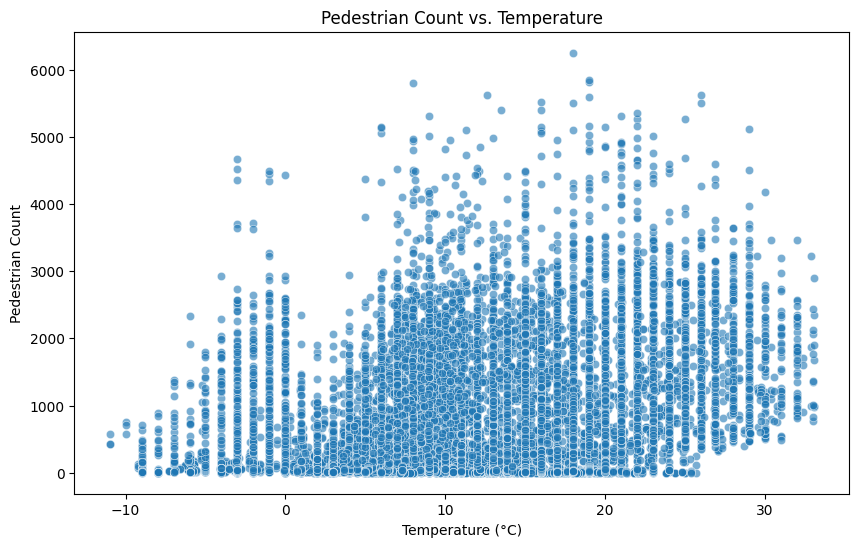

In [7]:
# Create a plot that shows the relationship between the number of pedestrians and the temperature

# Plot the data
plt.figure(figsize=(10, 6))
sns.scatterplot(x='temperature', y='pedestrians_count', data=df_hour, alpha=0.6)
plt.xlabel('Temperature (°C)')
plt.ylabel('Pedestrian Count')
plt.title('Pedestrian Count vs. Temperature')

# save plot
plt.savefig('Grafiken/Hour/pedestrian_counts_vs_temperature.png')
plt.show()

- the highest pedestrian count is at 20 degrees

### Time Series Analysis

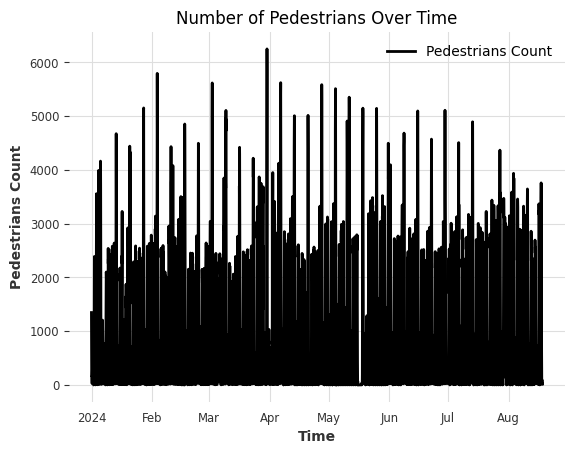

In [8]:
from darts import TimeSeries

# Convert 'timestamp' to datetime and remove timezone information
df_hour['timestamp'] = pd.to_datetime(df_hour['timestamp']).dt.tz_localize(None)

# Drop duplicates if any
df_hour = df_hour.drop_duplicates(subset='timestamp')

# Set 'timestamp' as the index
df_hour.set_index('timestamp', inplace=True)

# Resample to fill missing dates (you may need to choose a frequency that matches your data)
df_hour = df_hour.resample('h').ffill()  # Forward fill missing values

# Reset index if necessary (optional, depending on your use case)
df_hour.reset_index(inplace=True)

# Create a TimeSeries object with filling missing dates
ts = TimeSeries.from_dataframe(
    df_hour, 
    time_col='timestamp', 
    value_cols='pedestrians_count', 
    fill_missing_dates=True, 
    freq='h'  # Specify the frequency here (e.g., 'H' for hourly data)
)

# Plot the time series
ts.plot(label='Pedestrians Count')
plt.title('Number of Pedestrians Over Time')
plt.xlabel('Time')
plt.ylabel('Pedestrians Count')
plt.legend()

# save plot
plt.savefig('Grafiken/Hour/pedestrians_count_over_time.png')

plt.show()


### Average number of pedestrians per hour per day

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_7692/48252418.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df_hour.resample('H').ffill()  # Forward fill missing values


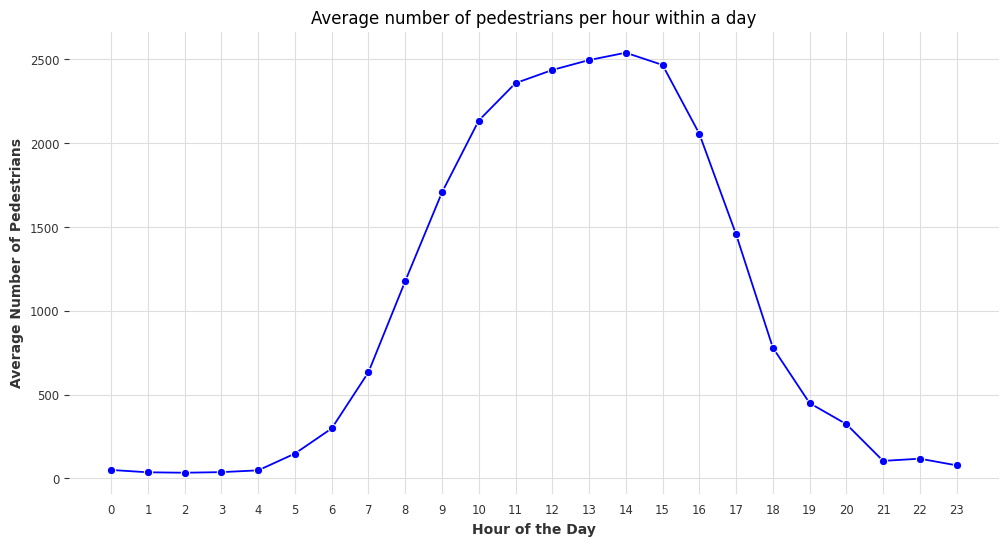

In [9]:
# Stellen Sie sicher, dass 'timestamp' eine Datetime-Spalte ist und als Index gesetzt ist
df_hour['timestamp'] = pd.to_datetime(df_hour['timestamp']).dt.tz_localize(None)
df_hour.set_index('timestamp', inplace=True)

# Resample to fill missing dates
df_hour = df_hour.resample('H').ffill()  # Forward fill missing values

# Extrahieren Sie die Stunde aus dem Timestamp
df_hour['hour'] = df_hour.index.hour

# Gruppieren Sie nach Stunde und berechnen Sie die durchschnittliche Anzahl der Passanten
hourly_pedestrians = df_hour.groupby('hour')['pedestrians_count'].mean()

# Plotten Sie die durchschnittliche Anzahl der Passanten pro Stunde innerhalb eines Tages
plt.figure(figsize=(12, 6))
sns.lineplot(x=hourly_pedestrians.index, y=hourly_pedestrians.values, marker='o', color='b')
plt.title('Average number of pedestrians per hour within a day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(range(24))  # Stellen Sie sicher, dass alle Stunden angezeigt werden
plt.grid(True)
# save plot
plt.savefig('Grafiken/Hour/average_pedestrians_per_hour.png')
plt.show()


- Most of the pedestrians are in the city from 12-3pm
- The least number of pedestrians are in the city from 3-6am and 19-11pm

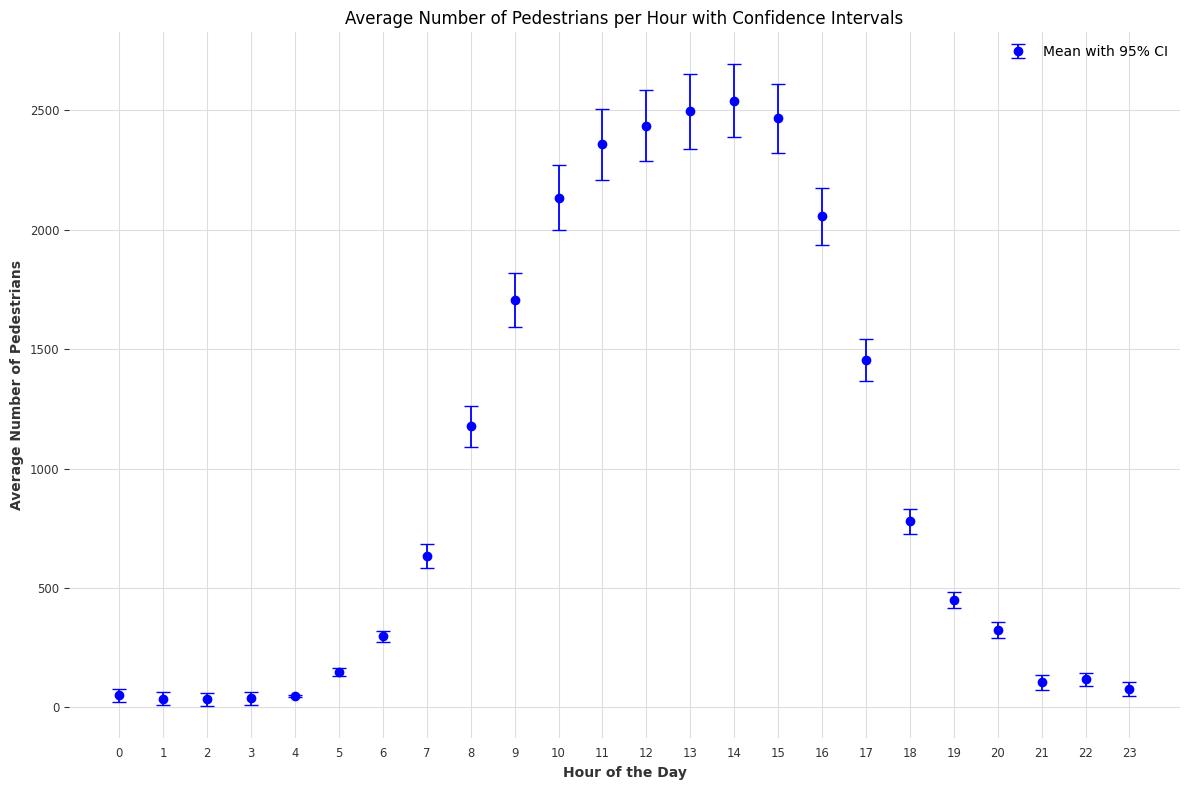

In [10]:
from scipy import stats 

# Create a column for the hour of the day
df_hour['hour_of_day'] = df_hour.index.hour

# Function to calculate the confidence interval
def get_confidence_interval(data):
    sample_size = data.shape[0]
    sample_mean = data.mean()
    sample_std = data.std()

    # Calculate the t-value for a 95% confidence interval (two-sided)
    t_value = stats.t.ppf(1-0.05/2, sample_size - 1) 

    # Calculate the half-width of the confidence interval
    ci_halfwidth = t_value * sample_std / np.sqrt(sample_size)

    # Calculate the lower and upper bounds of the confidence interval
    ci_lb = sample_mean - ci_halfwidth
    ci_ub = sample_mean + ci_halfwidth

    return ci_lb, ci_ub

# Group by hour of the day and calculate the average and confidence intervals
hourly_data = df_hour.groupby('hour_of_day')['pedestrians_count'].agg(['mean', 'std', 'count'])
hourly_data['ci'] = hourly_data.apply(lambda row: get_confidence_interval(df_hour[df_hour['hour_of_day'] == row.name]['pedestrians_count']), axis=1)

# Extract the lower and upper bounds of the confidence intervals
hourly_data['ci_lower'] = hourly_data['ci'].apply(lambda x: x[0])
hourly_data['ci_upper'] = hourly_data['ci'].apply(lambda x: x[1])

# Plotting the average number of pedestrians per hour with confidence intervals
plt.figure(figsize=(12, 8))
plt.errorbar(x=hourly_data.index, y=hourly_data['mean'], 
             yerr=(hourly_data['ci_upper'] - hourly_data['ci_lower']) / 2, 
             fmt='o', capsize=5, color='b', label='Mean with 95% CI')

plt.title('Average Number of Pedestrians per Hour with Confidence Intervals')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Number of Pedestrians')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
print(df_hour['month'].unique())


['December' 'January' 'February' 'March' 'April' 'May' 'June' 'July'
 'August']


### Average number of pedestrians per hour on an average day within a month

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_7692/3386617613.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df_hour.resample('H').ffill()


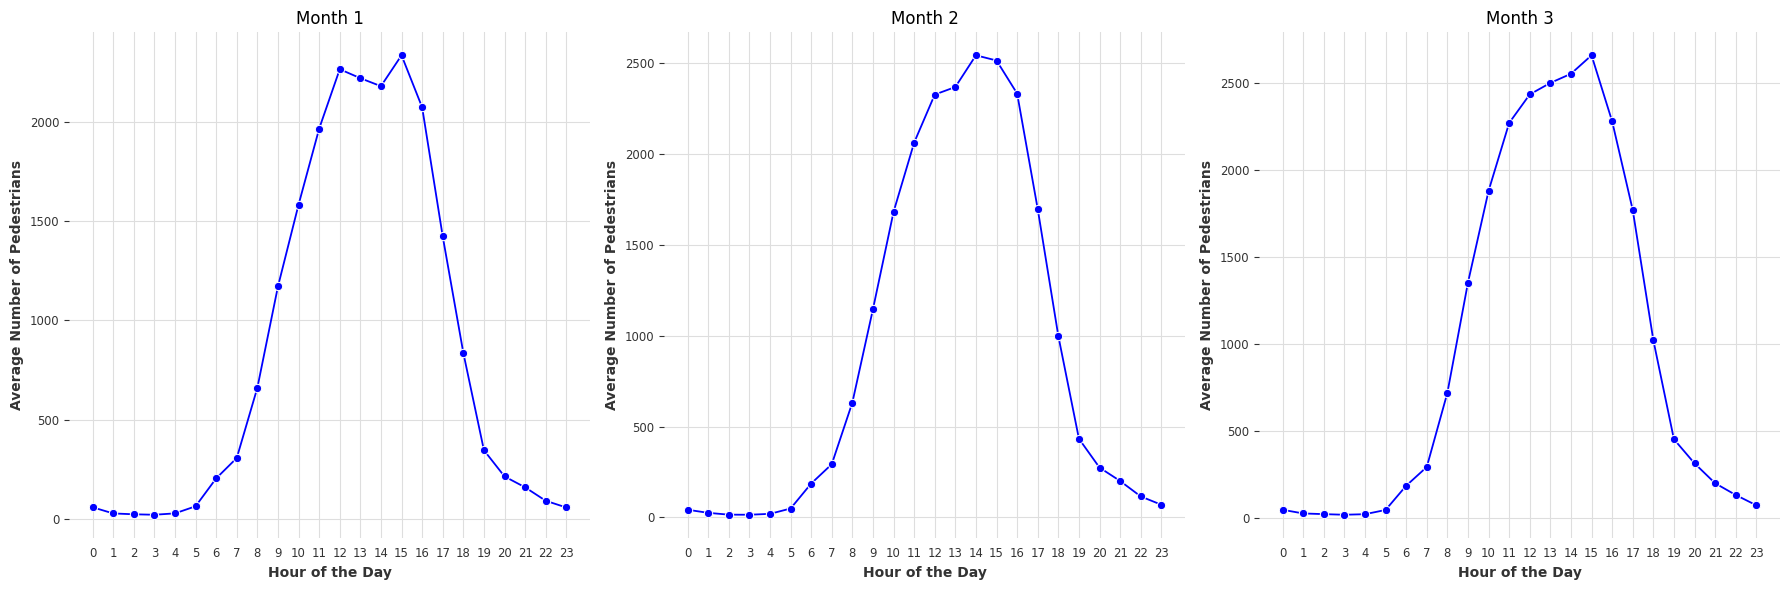

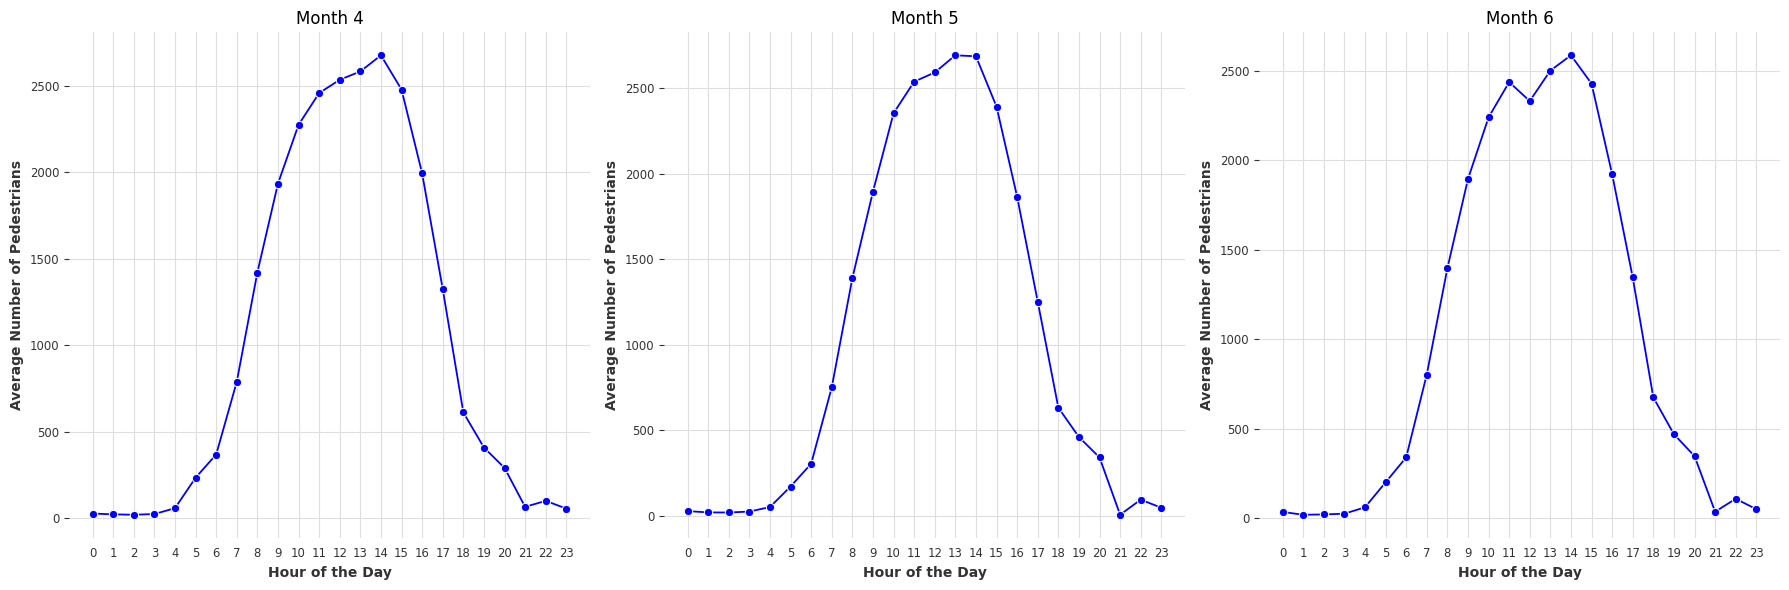

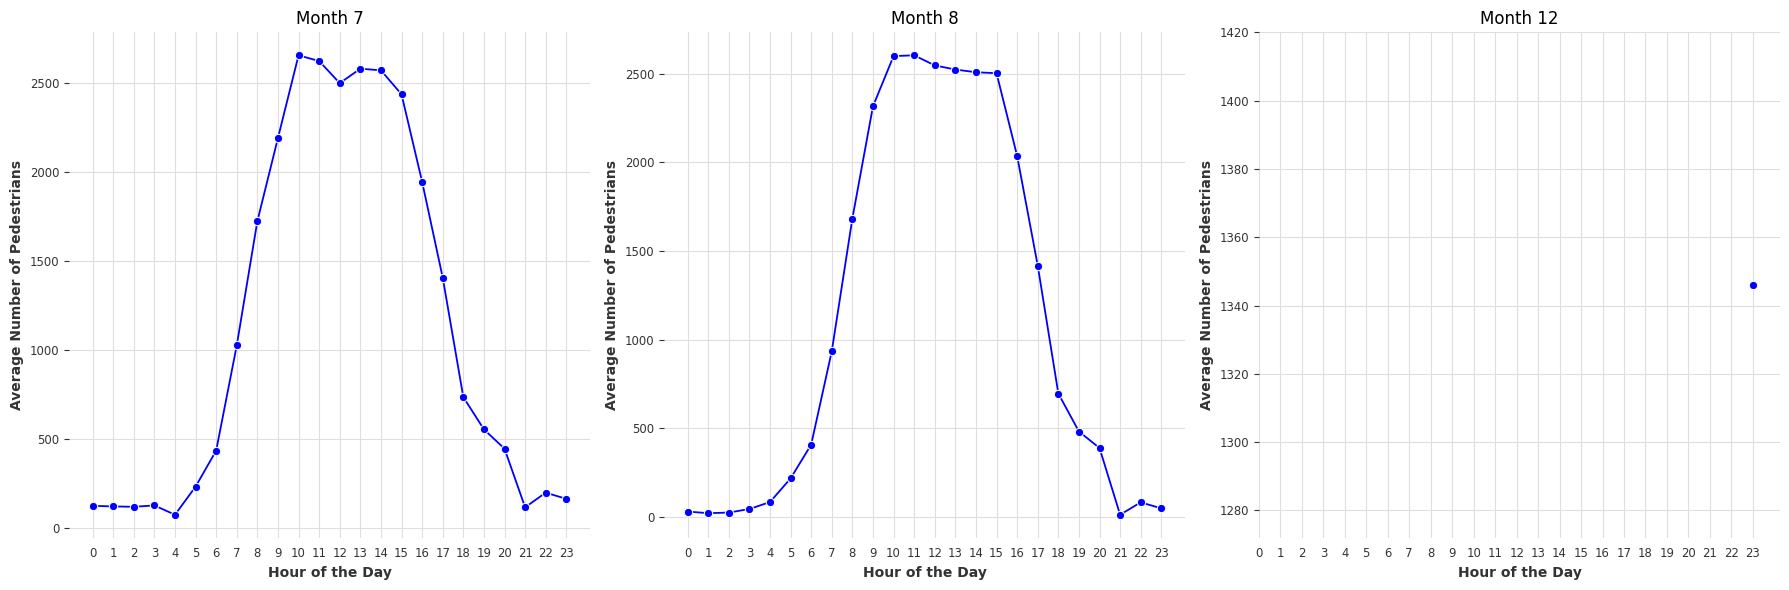

In [12]:
# Resample auf stündliche Frequenz, um fehlende Daten aufzufüllen
df_hour = df_hour.resample('H').ffill()

# Extrahieren des Monats, Tages und der Stunde aus dem Timestamp
df_hour['month'] = df_hour.index.month
df_hour['day'] = df_hour.index.day
df_hour['hour'] = df_hour.index.hour

# Für jeden Monat einen Plot erstellen
months = sorted(df_hour['month'].unique())
num_months = len(months)

# Definieren der Anzahl der Plots pro Reihe
plots_per_row = 3
fig, axes = plt.subplots(1, plots_per_row, figsize=(18, 6))

for i, month in enumerate(months):
    # Daten für den aktuellen Monat filtern
    df_month = df_hour[df_hour['month'] == month]
    
    # Gruppieren nach Tag und Stunde, dann Berechnen der durchschnittlichen Anzahl der Passanten pro Stunde an einem durchschnittlichen Tag
    daily_avg_hourly_pedestrians = df_month.groupby(['day', 'hour'])['pedestrians_count'].mean().groupby('hour').mean()
    
    # Plotten der durchschnittlichen Anzahl der Passanten pro Stunde an einem durchschnittlichen Tag im Monat
    sns.lineplot(x=daily_avg_hourly_pedestrians.index, y=daily_avg_hourly_pedestrians.values, marker='o', color='b', ax=axes[i % plots_per_row])
    axes[i % plots_per_row].set_title(f'Month {month}')
    axes[i % plots_per_row].set_xlabel('Hour of the Day')
    axes[i % plots_per_row].set_ylabel('Average Number of Pedestrians')
    axes[i % plots_per_row].set_xticks(range(24))
    axes[i % plots_per_row].grid(True)

    # Speichern und Anzeigen der Plots, wenn wir am Ende einer Reihe angekommen sind
    if (i + 1) % plots_per_row == 0 or i == num_months - 1:
        plt.tight_layout()
        plt.savefig('Grafiken/Hour/average_pedestrians_per_hour_month.png')
        plt.show()
        
        # Erstellen neuer Subplots für die nächste Reihe, wenn noch Monate übrig sind
        if i != num_months - 1:
            fig, axes = plt.subplots(1, plots_per_row, figsize=(18, 6))


- The number of pedestrians is highest in the city from 12-3pm
- The number of pedestrians is lowest in the city from 3-6am and 19-11pm
- The number of pedestrians vs hour of the day does not change much over the months

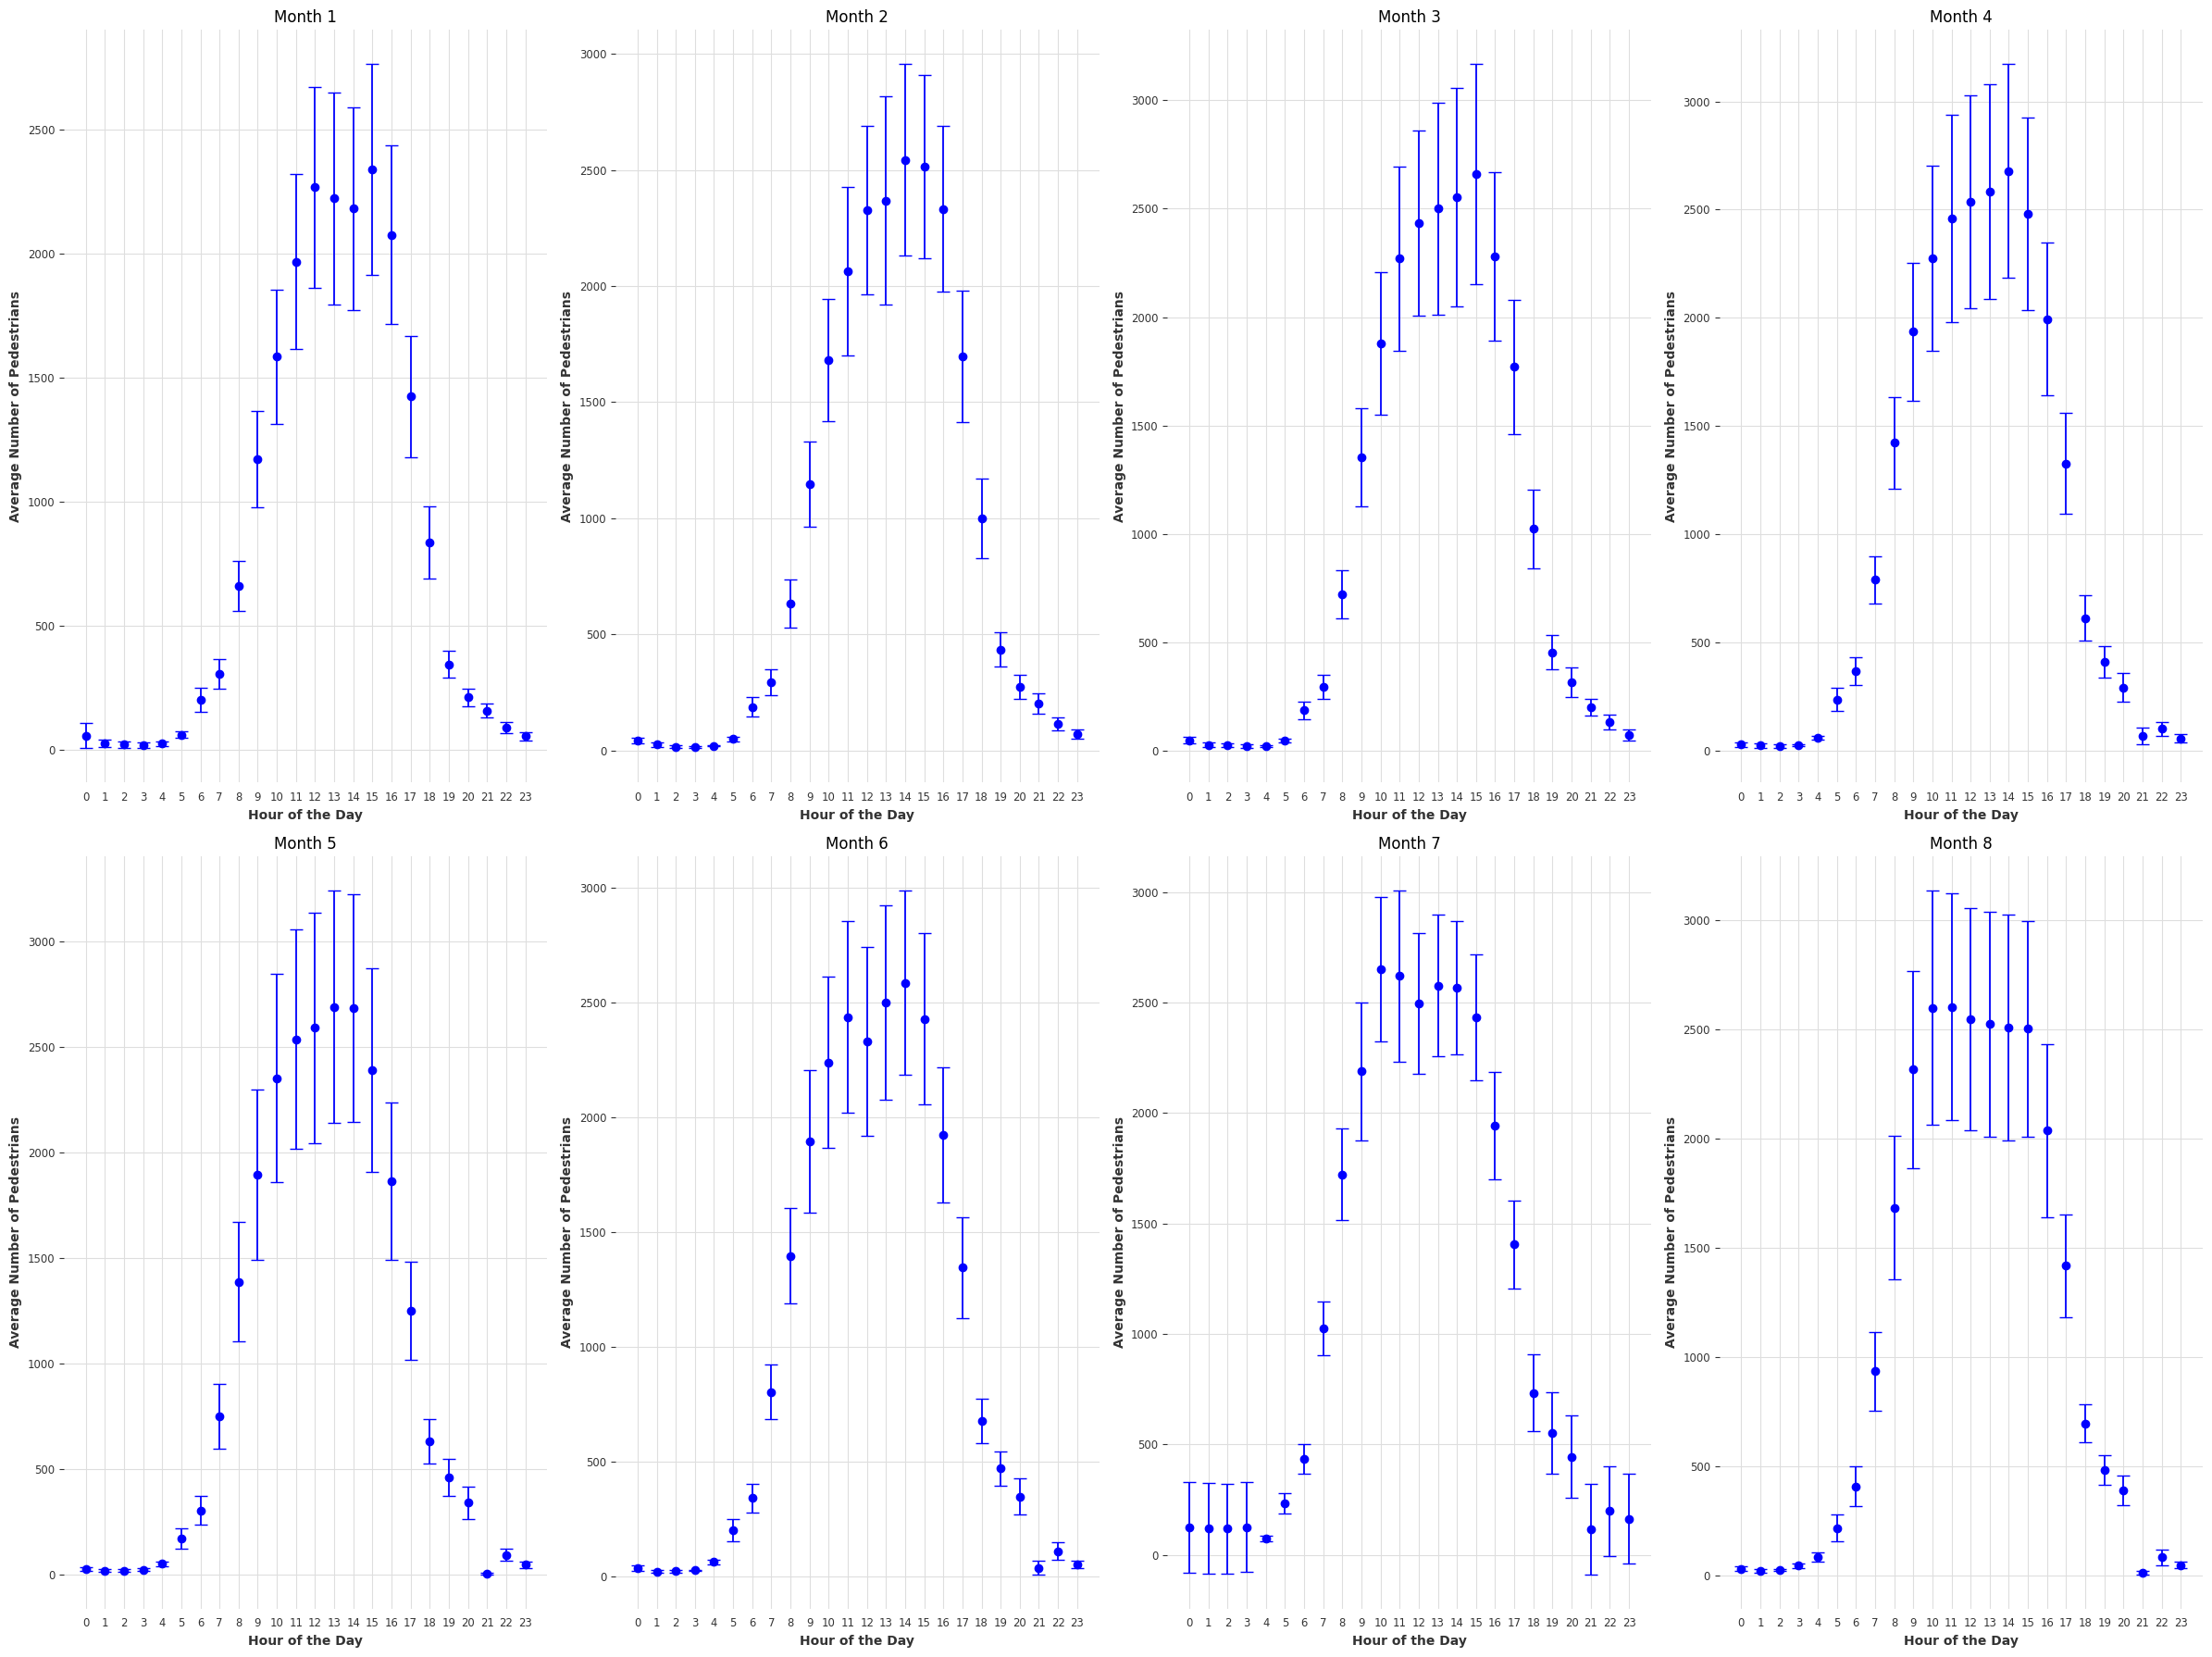

In [13]:
# Create columns for the hour of the day and month
df_hour['hour_of_day'] = df_hour.index.hour
df_hour['month'] = df_hour.index.month

# Group by hour of the day and month, then calculate mean and confidence intervals
hourly_monthly_data = df_hour.groupby(['hour_of_day', 'month'])['pedestrians_count'].agg(['mean', 'std', 'count'])
hourly_monthly_data['ci'] = hourly_monthly_data.apply(lambda row: get_confidence_interval(df_hour[(df_hour['hour_of_day'] == row.name[0]) & (df_hour['month'] == row.name[1])]['pedestrians_count']), axis=1)

# Extract the lower and upper bounds of the confidence intervals
hourly_monthly_data['ci_lower'] = hourly_monthly_data['ci'].apply(lambda x: x[0])
hourly_monthly_data['ci_upper'] = hourly_monthly_data['ci'].apply(lambda x: x[1])

# Plotting the results
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(24, 18))
axes = axes.flatten()

# Iterate through each month and plot the data
for month in range(1, 9
                ):
    # Filter data for the current month
    data_for_month = hourly_monthly_data.loc[(slice(None), month), :]

    # Plot the average number of pedestrians per hour with confidence intervals
    axes[month - 1].errorbar(x=data_for_month.index.get_level_values(0), 
                             y=data_for_month['mean'], 
                             yerr=(data_for_month['ci_upper'] - data_for_month['ci_lower']) / 2, 
                             fmt='o', capsize=5, color='b')

    axes[month - 1].set_title(f'Month {month}')
    axes[month - 1].set_xlabel('Hour of the Day')
    axes[month - 1].set_ylabel('Average Number of Pedestrians')
    axes[month - 1].set_xticks(range(0, 24))
    axes[month - 1].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('Grafiken/Day/average_pedestrians_hour_months_with_CI.png')
plt.show()

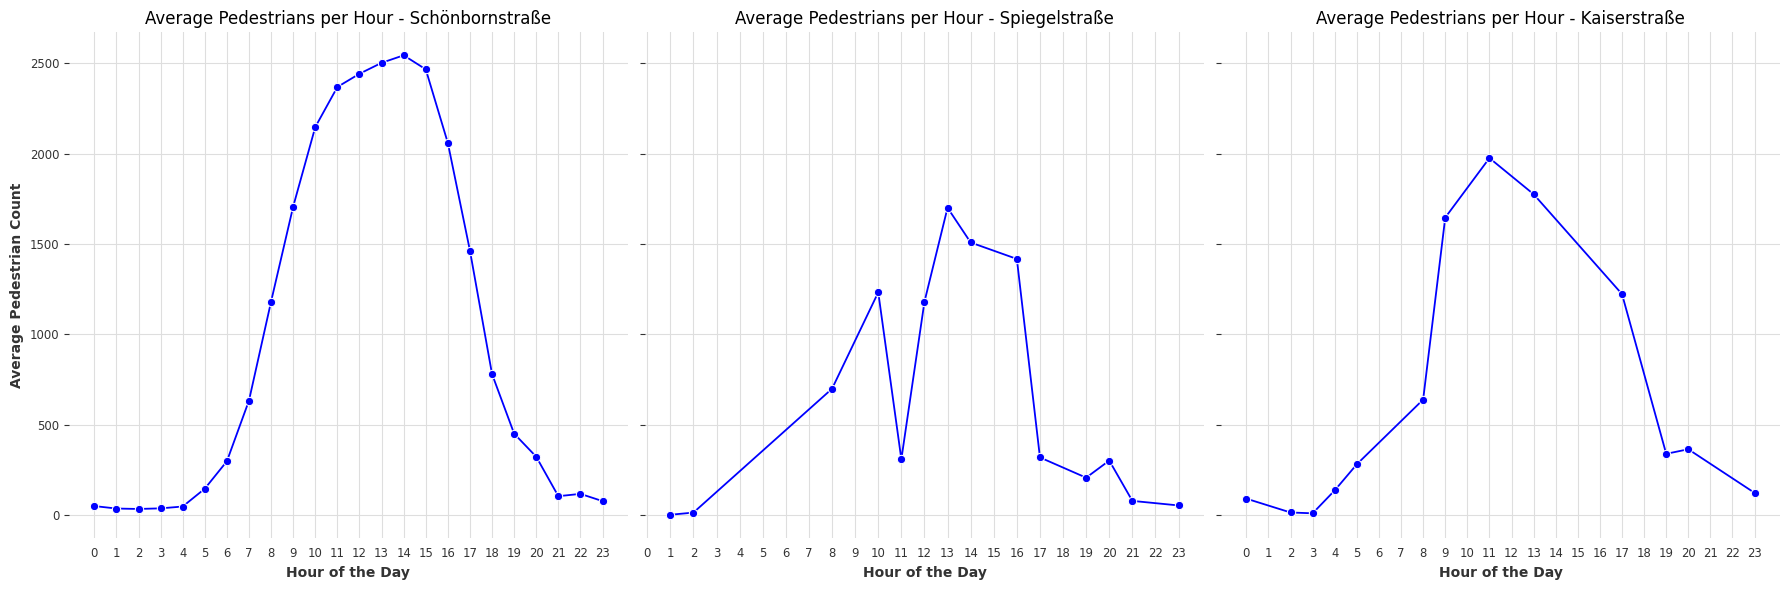

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get unique locations
locations = df_hour['location_name'].unique()

# Create a figure with subplots for each location
fig, axes = plt.subplots(1, len(locations), figsize=(18, 6), sharey=True)

for i, location in enumerate(locations):
    # Filter data for the current location
    df_location = df_hour[df_hour['location_name'] == location]
    
    # Group by hour and calculate the average pedestrian count per hour
    daily_avg_hourly_pedestrians = df_location.groupby(['hour'])['pedestrians_count'].mean()
    
    # Plot the average pedestrian count per hour
    sns.lineplot(x=daily_avg_hourly_pedestrians.index, y=daily_avg_hourly_pedestrians.values, marker='o', color='b', ax=axes[i])
    axes[i].set_title(f'Average Pedestrians per Hour - {location}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Average Pedestrian Count')
    axes[i].set_xticks(range(24))  # Ensure all hours are shown
    axes[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('Grafiken/Hour/average_pedestrians_per_hour_location.png')
plt.show()


In [15]:
import pandas as pd

# Get unique locations
locations = df_hour['location_name'].unique()

# Create an empty list to store peak hour information
peak_hours = []

for location in locations:
    # Filter data for the current location
    df_location = df_hour[df_hour['location_name'] == location]
    
    # Group by hour and calculate the average pedestrian count per hour
    daily_avg_hourly_pedestrians = df_location.groupby(['hour'])['pedestrians_count'].mean()
    
    # Find the peak hour (hour with the highest average pedestrian count)
    peak_hour = daily_avg_hourly_pedestrians.idxmax()
    peak_count = daily_avg_hourly_pedestrians.max()
    
    # Append the result to the peak_hours list
    peak_hours.append({'Location': location, 'Peak Hour': peak_hour, 'Average Pedestrian Count': peak_count})

peak_hours_df = pd.DataFrame(peak_hours)

# Display the peak hours for each location
print(peak_hours_df)


          Location  Peak Hour  Average Pedestrian Count
0  Schönbornstraße         14               2543.362445
1    Spiegelstraße         13               1700.000000
2     Kaiserstraße         11               1975.000000


In [16]:
import pandas as pd

# Get unique locations
locations = df_hour['location_name'].unique()

# Create an empty list to store hourly pedestrian count information
hourly_data = []

for location in locations:
    # Filter data for the current location
    df_location = df_hour[df_hour['location_name'] == location]
    
    # Group by hour and calculate the average pedestrian count per hour
    daily_avg_hourly_pedestrians = df_location.groupby(['hour'])['pedestrians_count'].mean().reset_index()
    
    # Append the result to the hourly_data list for each location and hour
    for index, row in daily_avg_hourly_pedestrians.iterrows():
        hourly_data.append({'Location': location, 'Hour': row['hour'], 'Average Pedestrian Count': row['pedestrians_count']})

# Create a DataFrame from the hourly data list
df_hourly = pd.DataFrame(hourly_data)

# Sort the DataFrame by location and hour for better readability
df_hourly_sorted = df_hourly.sort_values(by=['Location', 'Hour'])

df_hourly_sorted



,Location,Hour,Average Pedestrian Count
38,Kaiserstraße,0.0,91.000000
39,Kaiserstraße,2.0,14.500000
40,Kaiserstraße,3.0,10.000000
41,Kaiserstraße,4.0,137.000000
42,Kaiserstraße,5.0,281.333333
43,Kaiserstraße,8.0,639.000000
44,Kaiserstraße,9.0,1645.666667
45,Kaiserstraße,11.0,1975.000000
46,Kaiserstraße,13.0,1775.000000
47,Kaiserstraße,17.0,1222.500000


### Average number of pedestrians per hour on an average day within a season

/var/folders/4j/tc3nzkz10kd6976_d_mmfh680000gp/T/ipykernel_7692/998069043.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hour = df_hour.resample('H').ffill()


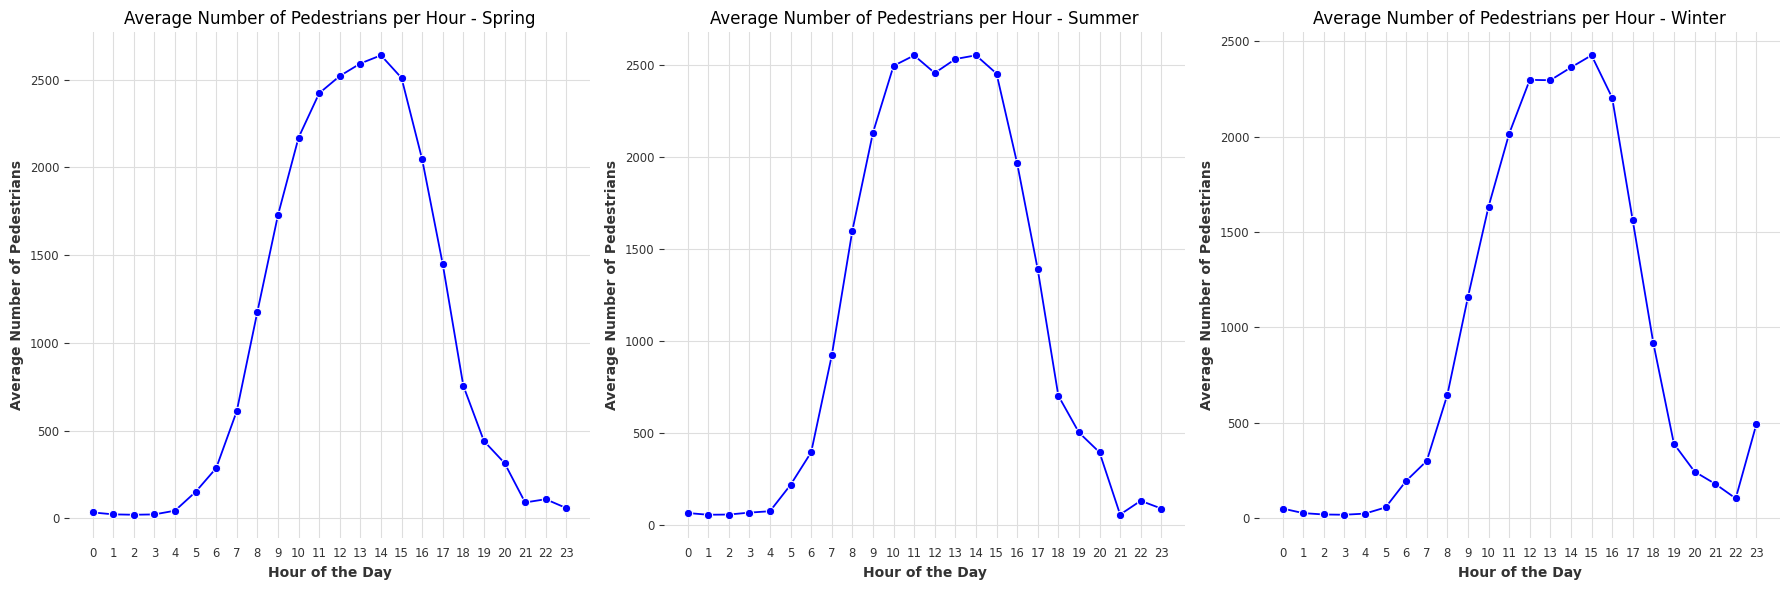

In [17]:
# Resample auf stündliche Frequenz, um fehlende Daten aufzufüllen
df_hour = df_hour.resample('H').ffill()

# Extrahieren von Stunde und Monat, um die Saison zu bestimmen
df_hour['month'] = df_hour.index.month
df_hour['hour'] = df_hour.index.hour

# Saison basierend auf dem Monat zuordnen
def assign_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'

df_hour['season'] = df_hour['month'].apply(assign_season)

# Saison-Liste, die für die Plots verwendet werden soll
seasons = ['Spring', 'Summer', 'Winter']

# Erstellen einer Figur mit drei nebeneinander liegenden Subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, season in enumerate(seasons):
    # Daten für die aktuelle Saison filtern
    df_season = df_hour[df_hour['season'] == season]
    
    # Gruppieren nach Monat und Stunde, dann Berechnen der durchschnittlichen Anzahl der Passanten pro Stunde an einem durchschnittlichen Tag
    daily_avg_hourly_pedestrians = df_season.groupby(['month', 'hour'])['pedestrians_count'].mean().groupby('hour').mean()
    
    # Plotten der durchschnittlichen Anzahl der Passanten pro Stunde an einem durchschnittlichen Tag in der Saison
    sns.lineplot(x=daily_avg_hourly_pedestrians.index, y=daily_avg_hourly_pedestrians.values, marker='o', color='b', ax=axes[i])
    axes[i].set_title(f'Average Number of Pedestrians per Hour - {season}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Average Number of Pedestrians')
    axes[i].set_xticks(range(24))  # Sicherstellen, dass alle Stunden angezeigt werden
    axes[i].grid(True)

# Layout anpassen, um Überlappungen zu vermeiden
plt.tight_layout()

# Speichern des Plots
plt.savefig('Grafiken/Hour/average_pedestrians_per_hour_season.png')
plt.show()  # Schließen des Plots, um Speicher freizugeben


- The number of pedestrians vs season does not change much over the seasons

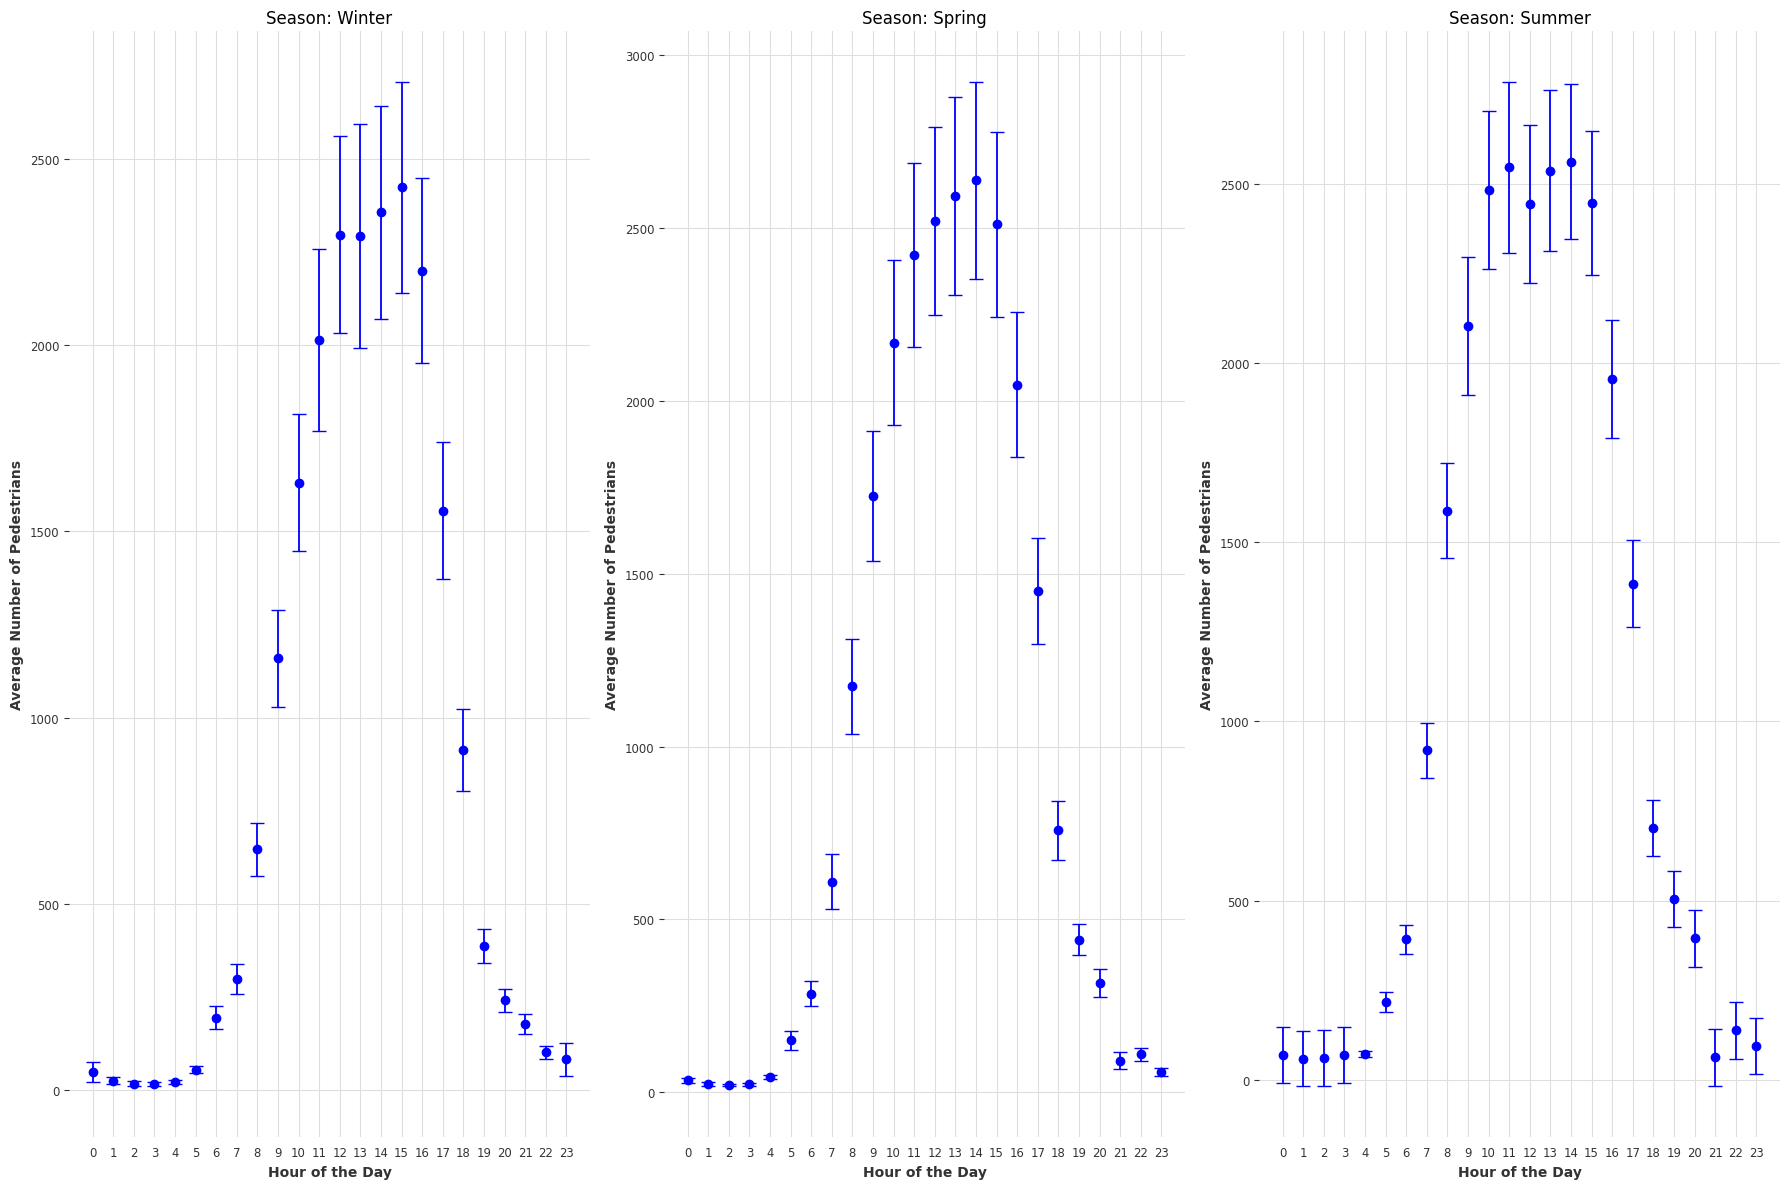

In [18]:
# Create columns for the hour of the day and season
df_hour['hour_of_day'] = df_hour.index.hour

# Function to determine the season based on the month
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Create a column for the season
df_hour['season'] = df_hour.index.month.map(get_season)

# Group by hour of the day and season, then calculate mean and confidence intervals
hourly_seasonal_data = df_hour.groupby(['hour_of_day', 'season'])['pedestrians_count'].agg(['mean', 'std', 'count'])
hourly_seasonal_data['ci'] = hourly_seasonal_data.apply(lambda row: get_confidence_interval(df_hour[(df_hour['hour_of_day'] == row.name[0]) & (df_hour['season'] == row.name[1])]['pedestrians_count']), axis=1)

# Extract the lower and upper bounds of the confidence intervals
hourly_seasonal_data['ci_lower'] = hourly_seasonal_data['ci'].apply(lambda x: x[0])
hourly_seasonal_data['ci_upper'] = hourly_seasonal_data['ci'].apply(lambda x: x[1])

# Plotting the results
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 12))
axes = axes.flatten()

seasons = ['Winter', 'Spring', 'Summer']

# Iterate through each season and plot the data
for i, season in enumerate(seasons):
    # Filter data for the current season
    data_for_season = hourly_seasonal_data.loc[(slice(None), season), :]

    # Plot the average number of pedestrians per hour with confidence intervals
    axes[i].errorbar(x=data_for_season.index.get_level_values(0), 
                     y=data_for_season['mean'], 
                     yerr=(data_for_season['ci_upper'] - data_for_season['ci_lower']) / 2, 
                     fmt='o', capsize=5, color='b')

    axes[i].set_title(f'Season: {season}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Average Number of Pedestrians')
    axes[i].set_xticks(range(0, 24))
    axes[i].grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot
plt.savefig('Grafiken/Day/average_pedestrians_hour_seasons_with_CI.png')
plt.show()


## Correlation with Weather Conditions


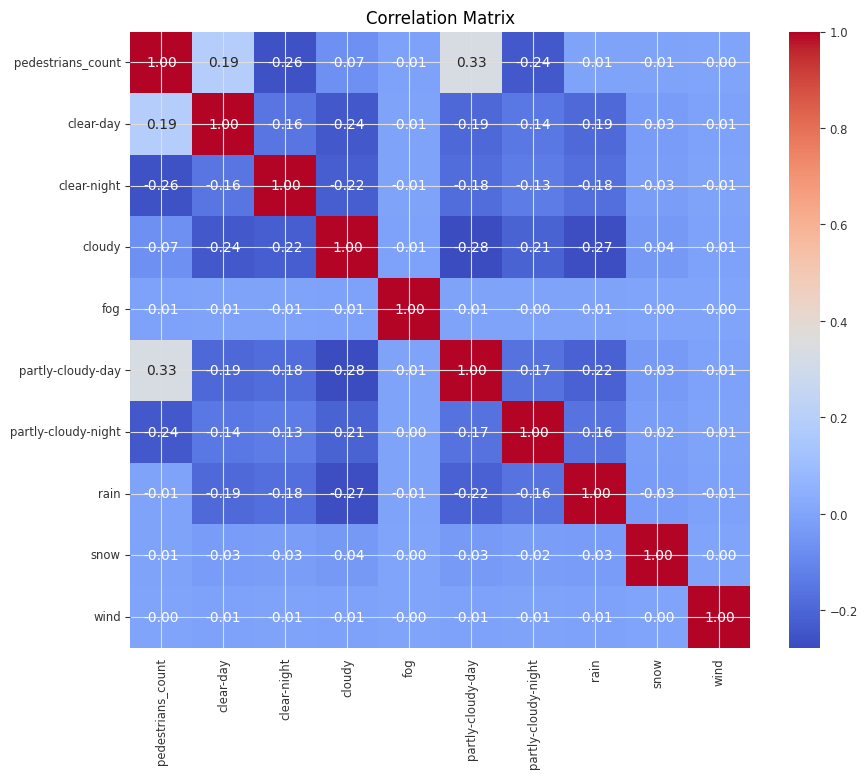

In [19]:


# One-hot encode weather conditions
weather_encoded = pd.get_dummies(df_hour['weather_condition'])

# Combine with the original data
data_encoded = pd.concat([df_hour, weather_encoded], axis=1)

# Plot correlation matrix
correlation = data_encoded[['pedestrians_count'] + list(weather_encoded.columns)].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
# save plot
plt.savefig('Grafiken/Hour/correlation_matrix_weather_conditions.png')
plt.show()


- the highest pedestrian count is on a partly cloudy day, but the correlation of 0.33 is not very strong